In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import time
import optax
import matplotlib.pyplot as plt 
from jax.flatten_util import ravel_pytree
from functools import partial

import piml_library.lagrangian as lgr
import piml_library.hamiltonian as ham
import piml_library.util as util
import piml_library.plotting as plotting

In [2]:
@jax.jit
#L((t, q, v))
def L_analytical(state):
    q = lgr.coordinate(state)
    v = lgr.velocity(state)
    q_flat, _ = ravel_pytree(q)
    v_flat, _ = ravel_pytree(v)
    
    T = 0.5 * jnp.sum(v_flat**2)
    V = 0.5 * jnp.sum(q_flat**2)
    return T - V

In [3]:
@jax.jit
#H((t, q, p))
def H_analytical(state, m=1.0, k=1.0):
    q = ham.coordinate(state) 
    p = ham.momentum(state) 
    
    q_flat, _ = ravel_pytree(q) 
    p_flat, _ = ravel_pytree(p) 
    
    T = 0.5 / m * jnp.sum(p_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

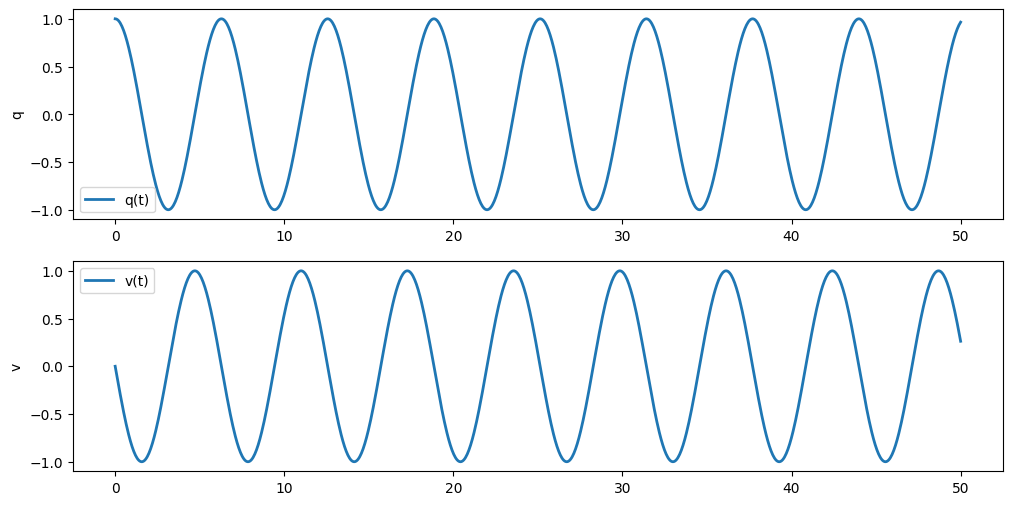

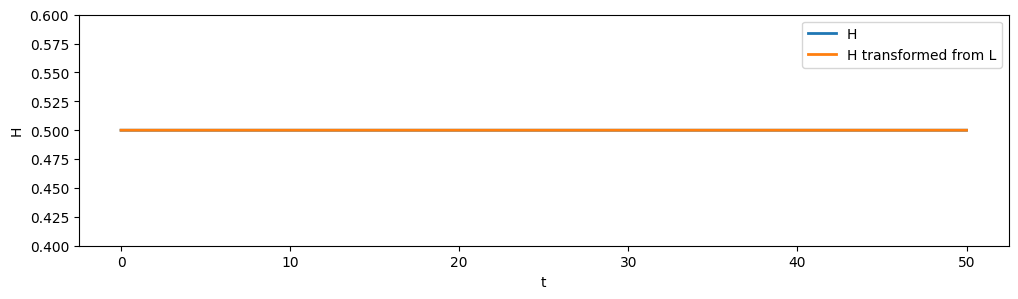

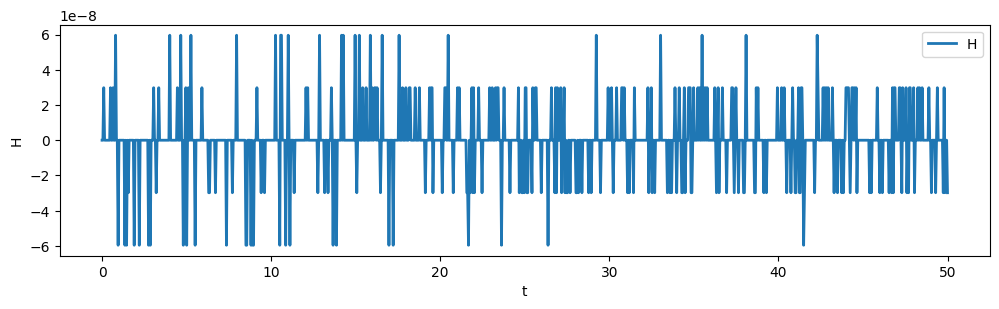

In [4]:
ds = lgr.state_derivative(L_analytical)
solver = util.ode_solver(ds)
initial_state = (0.0, jnp.array([1.0]), jnp.array([0.0]))
t_eval = jnp.linspace(0.0, 50.0, 1000)

lgr_states = solver(initial_state, t_eval)
lgr_to_ham_state_fn = ham.lagrangian_state_to_hamiltonian_state(L_analytical)
ham_states = jax.vmap(lgr_to_ham_state_fn)(lgr_states)

H = jax.vmap(H_analytical)(ham_states)
L = jax.vmap(L_analytical)(lgr_states)
H_transform_fn = ham.lagrangian_to_hamiltonian(L_analytical)
L_transform_fn = ham.hamiltonian_to_lagrangian(H_analytical)
H_tr = jax.vmap(H_transform_fn)(ham_states)
L_tr = jax.vmap(L_transform_fn)(lgr_states)


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(lgr_states[0], lgr_states[1], label='q(t)', linewidth=2)
plt.ylabel('q')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(lgr_states[0], lgr_states[2], label='v(t)', linewidth=2)
plt.ylabel('v')
plt.legend()

plt.figure(figsize=(12, 3))
plt.plot(lgr_states[0], H , label='H', linewidth=2)
plt.plot(ham_states[0], H_tr, label='H transformed from L', linewidth=2)
plt.xlabel('t')
plt.ylabel('H')
plt.legend()
plt.ylim(0.4, 0.6)

plt.figure(figsize=(12, 3))
plt.plot(lgr_states[0], H - H_tr, label='H', linewidth=2)
plt.xlabel('t')
plt.ylabel('H')
plt.legend()
#plt.ylim(-0.1, 0.1)